# Imports

In [1]:
"""
Demo single-file notebook to train a ConvNet on CIFAR10 using SoftHebb, an unsupervised, efficient and bio-plausible learning algorithm.
Based on demo.py from the official repo
"""
import math
import warnings
from tqdm.notebook import tqdm
import datetime
from pathlib import Path
from copy import deepcopy
from collections import OrderedDict
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import random

import numpy as np


import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.nn.modules.utils import _pair
from torch.optim.lr_scheduler import StepLR
import torchvision

def seed_init_fn(seed):
    seed = seed % 2 ** 32
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

# Device
device = torch.device('cuda:0')

# For Lateral Support

In [2]:
def create_circular_mask_batched(h, w, centers, radii):
    """
    Create circular masks for batched inputs using PyTorch tensors.
    
    Args:
    - h: Height of the grid (or a tensor of heights for each batch).
    - w: Width of the grid (or a tensor of widths for each batch).
    - centers: A tensor of shape (batch_size, 2) representing the (y, x) center of the circle for each batch.
               If None, defaults to the center of each grid.
    - radii: A tensor of shape (batch_size,) representing the radius of the circle for each batch.
             If None, defaults to the minimum distance from the center to the edges of each grid.
    
    Returns:
    - A boolean mask (tensor) of shape (batch_size, h, w), where True represents points inside the circle.
    """
    batch_size = centers.size(0)

    # Ensure `h` and `w` are tensors if they are scalar inputs
    if isinstance(h, int):
        h = torch.tensor([h] * batch_size)
    if isinstance(w, int):
        w = torch.tensor([w] * batch_size)

    # Create the grid for each batch (meshgrid for each image)
    Y, X = torch.meshgrid([torch.arange(h.max()), torch.arange(w.max())], indexing='ij')
    
    # Expand X and Y to match batch size and grid size
    X = X.unsqueeze(0).expand(batch_size, -1, -1).float().to(device=centers.device)
    Y = Y.unsqueeze(0).expand(batch_size, -1, -1).float().to(device=centers.device)

    # Calculate the distance of each point in the grid from the center of the circle
    dist_from_center = torch.sqrt((X - centers[:, 1].unsqueeze(1).unsqueeze(2)) ** 2 + 
                                  (Y - centers[:, 0].unsqueeze(1).unsqueeze(2)) ** 2)

    # Create a mask for each batch based on the radius
    masks = dist_from_center <= radii.unsqueeze(1).unsqueeze(2)

    return masks

# Model architecture definition

In [3]:
class SoftHebbLinear(nn.Module):
    def __init__(
            self,
            in_channels: int,
            out_channels: int,
            t_invert: float = 12, # Invert of the temperature for softmax
            # Lateral Support params
            n_lateral_neighbors=0, # 0 - turn off lateral support
            lateral_period=None, # None - turn off 2D
            lateral_gain_coef=0, # 0 - no effect
    ) -> None:
        """
        This is the implementation of Linear layer trained with SoftHebb method.
        The code is adapted and augmented from https://github.com/NeuromorphicComputing/SoftHebb/tree/main
        """
        super(SoftHebbLinear, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        weight_range = 14 / math.sqrt(in_channels)
        self.weight = nn.Parameter(weight_range * torch.randn((out_channels, in_channels)))
        self.t_invert = torch.tensor(t_invert)
        # Lateral Support params
        self.n_lateral_neighbors = n_lateral_neighbors
        self.lateral_period = lateral_period
        self.lateral_gain_coef = lateral_gain_coef

    def forward(self, x):
        weighted_input = F.linear(x, self.weight, None)

        if self.training:
            # Post-synaptic activation, for plastic update, is weighted input passed through a softmax.
            # Non-winning neurons (those not with the highest activation) receive the negated post-synaptic activation.
            batch_size, out_channels = weighted_input.shape
            flat_weighted_inputs = weighted_input
            # Compute the winner neuron for each batch element
            flat_softwta_activs = torch.softmax(self.t_invert * flat_weighted_inputs, dim=1)
            flat_softwta_activs = - flat_softwta_activs  # Turn all postsynaptic activations into anti-Hebbian
            win_neurons = torch.argmax(flat_weighted_inputs, dim=1)  # winning neuron for each pixel in each input
            competing_idx = torch.arange(flat_weighted_inputs.size(0))  # indices of all pixel-input elements
            # Turn winner neurons' activations back to hebbian (pqlet - i.e. make positive, not anti-hebbian term)
            flat_softwta_activs[:, win_neurons] = - flat_softwta_activs[:, win_neurons]

            # Lateral Support
            if self.n_lateral_neighbors > 0:
                # 1D case
                if self.lateral_period is None:
                    # Vectorize the generation of indices for lateral neighbors
                    # Range of neighbor offsets
                    neighbors_range = torch.hstack(
                        (torch.arange(-self.n_lateral_neighbors, 0, device=win_neurons.device),
                        torch.arange(1, self.n_lateral_neighbors + 1, device=win_neurons.device))
                    )
                    # Create the neighbors for each neuron by adding the offsets
                    ids_support = win_neurons.unsqueeze(1) + neighbors_range.unsqueeze(0)
                    # Clip the resulting indices to be within valid range
                    ids_support = torch.clip(ids_support, min=0, max=flat_softwta_activs.size(0) - 1).T
                    # Set values
                    flat_softwta_activs[:, ids_support] = \
                        + flat_softwta_activs[:, ids_support] \
                        - self.lateral_gain_coef * flat_softwta_activs[competing_idx, win_neurons].unsqueeze(1)
                # 2D case
                else:
                    assert type(self.lateral_period)==int
                    # Assume win_neurons are 1D indices of neurons, and n_lateral_period is the number of columns (width of 2D grid)
                    n_rows = flat_softwta_activs.size(1) // self.lateral_period  # Total rows in the 2D grid
                    # Convert winning neurons' 1D id to 2D
                    centers_from_win = torch.stack((
                        win_neurons.divide(self.lateral_period, rounding_mode='floor'),
                        win_neurons.remainder(self.lateral_period),
                    )).T
                    # Get circular 2D masks - boolean only by now
                    radii = self.n_lateral_neighbors * torch.ones(len(win_neurons), device=win_neurons.device)
                    mask_lsupp = create_circular_mask_batched(n_rows, self.lateral_period, 
                                                                centers=centers_from_win, 
                                                                radii=radii
                                                                )
                    # Apply masks
                    flat_softwta_activs = \
                        flat_softwta_activs \
                        - self.lateral_gain_coef * flat_softwta_activs[competing_idx, win_neurons].unsqueeze(1) * mask_lsupp.flatten(1)

            softwta_activs = flat_softwta_activs
            # ===== compute plastic update Δw = y*(x - u*w) = y*x - (y*u)*w =======================================
            yx = torch.matmul(softwta_activs.T, x)

            yu = torch.multiply(softwta_activs, weighted_input)
            yu = torch.sum(yu.t(), dim=1).unsqueeze(1)
            
            delta_weight = yx - yu.view(-1, 1,) * self.weight
            delta_weight.div_(torch.abs(delta_weight).amax() + 1e-30)  # Scale [min/max , 1]
            self.weight.grad = delta_weight  # store in grad to be used with common optimizers

        return weighted_input


class ModelSoftHebb(nn.Module):
    def __init__(self, in_channels, out_channels, t_invert, layer_kwargs=None):
        super(ModelSoftHebb, self).__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels

        if layer_kwargs is None:
            layer_kwargs = {}
        self.layer_kwargs = layer_kwargs 
        
        self.bn1 = nn.BatchNorm1d(in_channels, affine=False)
        self.ff1 = SoftHebbLinear(
            in_channels=in_channels, 
            out_channels=out_channels, 
            t_invert=t_invert,
            **self.layer_kwargs
        ) 

    def forward(self, x):
        out = self.ff1(self.bn1(x))
        return out

# Optimization definitions - Scheduler, Optimizer

In [4]:
class TensorLRSGD(optim.SGD):
    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step, using a non-scalar (tensor) learning rate.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            weight_decay = group['weight_decay']
            momentum = group['momentum']
            dampening = group['dampening']
            nesterov = group['nesterov']

            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad
                if weight_decay != 0:
                    d_p = d_p.add(p, alpha=weight_decay)
                if momentum != 0:
                    param_state = self.state[p]
                    if 'momentum_buffer' not in param_state:
                        buf = param_state['momentum_buffer'] = torch.clone(d_p).detach()
                    else:
                        buf = param_state['momentum_buffer']
                        buf.mul_(momentum).add_(d_p, alpha=1 - dampening)
                    if nesterov:
                        d_p = d_p.add(buf, alpha=momentum)
                    else:
                        d_p = buf

                p.add_(-group['lr'] * d_p)
        return loss

# Dataset definition - CIFAR10

In [5]:
class FastCIFAR10(torchvision.datasets.CIFAR10):
    """
    Improves performance of training on CIFAR10 by removing the PIL interface and pre-loading on the GPU (2-3x speedup).

    Taken from https://github.com/y0ast/pytorch-snippets/tree/main/fast_mnist
    """

    def __init__(self, *args, **kwargs):
        device = kwargs.pop('device', "cpu")
        super().__init__(*args, **kwargs)

        self.data = torch.tensor(self.data, dtype=torch.float, device=device).div_(255)
        self.data = torch.movedim(self.data, -1, 1)  # -> set dim to: (batch, channels, height, width)
        self.targets = torch.tensor(self.targets, device=device)

    def __getitem__(self, index: int):
        """
        Parameters
        ----------
        index : int
            Index of the element to be returned

        Returns
        -------
            tuple: (image, target) where target is the index of the target class
        """
        img = self.data[index]
        target = self.targets[index]

        return img, target

# Prepare model, optimizers, data

In [6]:
# seed training 
seed_init_fn(42)

# Layer kwargs
layer_kwargs_2D = {
    'n_lateral_neighbors':1,
    'lateral_period':30,
    'lateral_gain_coef':-0.3,
}
# Model 
model = ModelSoftHebb(
    in_channels=3*32*32, 
    out_channels=450, 
    t_invert=300,
    layer_kwargs=layer_kwargs_2D,
)
model.to(device)

unsup_optimizer = TensorLRSGD([
    # Basically just SGD despite the complicated class, becaouse of just 'lr' param
    {"params": model.ff1.parameters(), "lr": -0.08, },  # SGD does descent, but we assign the positive updates, so set lr to negative
], lr=0)

# Datasets and dataloaders
trainset = FastCIFAR10('./data', train=True, download=True)
unsup_trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=0, pin_memory=True)

Files already downloaded and verified


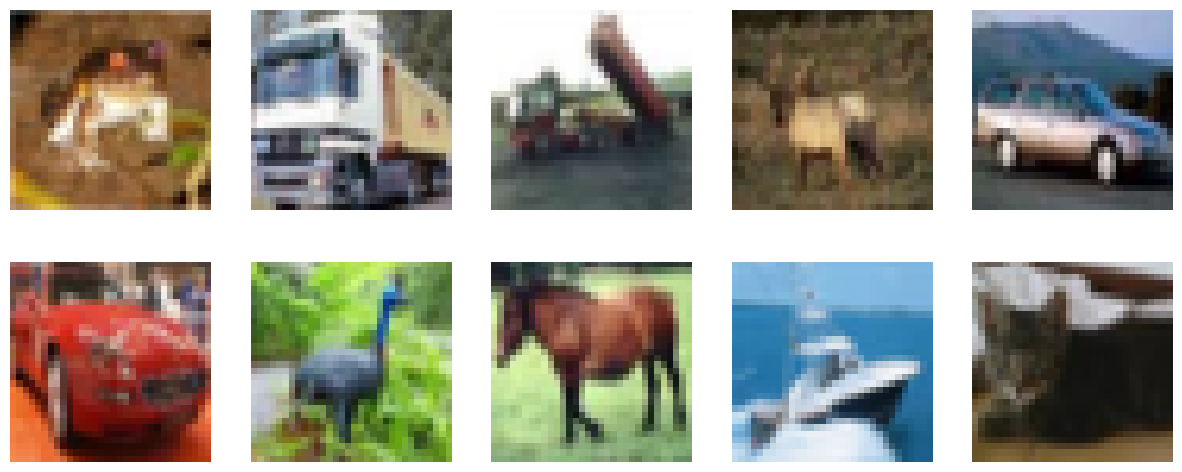

In [7]:
# Plot a few images
import matplotlib.pyplot as plt

# Plot 10 images in 2 rows
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for idx, ax in enumerate(axs.flatten()):
    img, _ = trainset[idx]
    img = img.permute(1, 2, 0)  # Change from (C, H, W) to (H, W, C)
    ax.imshow(img)
    ax.axis('off')

plt.show()

# Unsupervised training

In [8]:
n_epochs_unsup=1
# Unsupervised training with SoftHebb
print(f'{datetime.datetime.now().strftime(f"%H-%M-%S")}| Unsupervised Training - {n_epochs_unsup} epoch')

dd_ker_vals = {'ff1':[]}

for epoch in range(n_epochs_unsup):
    running_loss = 0.0
    for step, data in tqdm(enumerate(unsup_trainloader, 0), total=len(unsup_trainloader)):
        global_step = (step+1 + epoch*len(unsup_trainloader))
        
        inputs, _ = data
        inputs = inputs.flatten(1)
        inputs = inputs.to(device)

        # zero the parameter gradients
        unsup_optimizer.zero_grad()

        # forward + update computation
        with torch.no_grad():
            outputs = model(inputs)

        # optimize
        unsup_optimizer.step()
                    
        # save kernels for plots
        ker_vals = deepcopy(model.ff1.weight.cpu().detach())
        dd_ker_vals['ff1'].append(ker_vals)

print(f'{datetime.datetime.now().strftime(f"%H-%M-%S")}| End of Unsupervised Training - {n_epochs_unsup} epoch')

20-36-15| Unsupervised Training - 1 epoch


  0%|          | 0/782 [00:00<?, ?it/s]

20-36-22| End of Unsupervised Training - 1 epoch


# Plot weights of the output neurons

**Generating the animation below is memory-heavy !** 

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML
import matplotlib
import torchvision.utils as vutils
matplotlib.rcParams['animation.embed_limit'] = 500 # MB

weights_saved = dd_ker_vals['ff1']

n_images= 450
epoch_list_weights = ([(item_[np.arange(n_images)].view(-1,3,32,32)) for item_ in weights_saved[150::2]])

plot_weights = []
for list_weights in (epoch_list_weights):
    plot_weights.append(vutils.make_grid(list_weights, nrow=layer_kwargs_2D['lateral_period'], padding=2, normalize=True))

fig = plt.figure(figsize=(14, 6))
plt.axis("off")
ims = [[plt.imshow(np.transpose(w_plot,(1,2,0)), animated=True)] for w_plot in (plot_weights[:])]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

# Save gif demonstration

In [14]:
from PIL import Image

ch, h, w = plot_weights[0].shape

# Make a gif 
ims_gif = np.array( \
    [np.array(Image.fromarray( \
    (np.transpose(w_plot,(1,2,0)).numpy() * 255).astype(np.uint8)).resize(size=(int(w/1.8), int(h/1.8)), \
    resample=Image.Resampling.BILINEAR) \
        ) for w_plot in (plot_weights[:])])
# import imageio
# imageio.mimsave('ims_sup_cifar10.gif', ims_gif)
print(f'Num images: {len(ims_gif)}')

Num images: 316


In [16]:
import imageio
import numpy as np

# n_frames, h, w, ch = ims_gif.shape
frames = ims_gif[70:-100,:int(h*0.8),:int(w/2),:]

# Specify the output file path
dir = Path('image-pres')
dir.mkdir(exist_ok=True)
output_file = dir / 'training_ims.gif'

# Create a writer object
with imageio.get_writer(output_file, mode='I', duration=8) as writer:
    for frame in frames:
        writer.append_data(frame)

print(f"GIF saved to {output_file}")

GIF saved to image-pres\training_ims.gif
